Update: Study the relation between classification accuracy and quantity of labeled and unlabeled documents.

In [1]:
# Import packages and libraries
import numpy as np
import random as rnd
import re
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics

from time import time
from pprint import pprint
from copy import deepcopy
from wordcloud import WordCloud 
from Semi_EM_NB import Semi_EM_MultinomialNB
from os import path
from PIL import Image

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
def remove_noise(sentence):
    result = ''
    poster = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    wordlist = re.sub(r"\n|(\\(.*?){)|}|[!$%^&*#()_+|~\-={}\[\]:\";'<>?,.\/\\]|[0-9]|[@]", ' ', sentence) # remove punctuation
    wordlist = re.sub('\s+', ' ', wordlist) # remove extra space
    wordlist_normal = [poster.stem(word.lower()) for word in wordlist.split()] # restore word to its original form (stemming)
    wordlist_normal = [lemmatizer.lemmatize(word, pos='v') for word in wordlist_normal] # restore word to its root form (lemmatization)
    wordlist_clean = [word for word in wordlist_normal if word not in stopword_set] # remove stopwords
    result = ' '.join(wordlist_clean)
    return result

In [3]:
def cross_validation(clf, data_X, data_y, unlabeled=None, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_scores = list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    avg_accuracy = 0
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==None:
            cv_clf.fit(train_X, train_y)
        else:
            cv_clf.fit(train_X, train_y, unlabeled)
        pred = cv_clf.predict(valid_X)
        scores = dict()
        scores['accuracy'] = metrics.accuracy_score(valid_y, pred)
        scores['recall'] = metrics.recall_score(valid_y, pred, average='macro')
        scores['precision'] = metrics.precision_score(valid_y, pred, average='macro')
        scores['f1_score'] = metrics.f1_score(valid_y, pred, average='macro')
        train_scores.append(scores)
        avg_accuracy += scores['accuracy']
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % (avg_accuracy/n_folds))
    return train_scores, train_time

In [4]:
def show_topK(classifier, vectorizer, categories, K=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    nrows, ncols = 5, 4
    fig, axes = plt.subplots(figsize=(50, 40), nrows=nrows, ncols=ncols)
    #d = path.dirname(__file__)
    circle_mask = np.array(Image.open(path.join('./', "circle.png")))
    for i, category in enumerate(categories):
        topK = np.argsort(classifier.coef_[i])[-K:]
        text = " ".join(feature_names[topK])
        print("%s: %s" % (category, text))
        wordcloud = WordCloud(background_color="white", mask=circle_mask).generate(text)
        axes[i//ncols, i%ncols].imshow(wordcloud, cmap=plt.cm.cool_r, interpolation='bilinear')
        axes[i//ncols, i%ncols].axis("off")
        axes[i//ncols, i%ncols].set_title(category, fontweight="bold", size=24)
    plt.show()

In [5]:
# Load data set with class labels and split into train and test set
test_size_ratio = 0.2
data_Xy = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
category_names = data_Xy.target_names # text names of all categories
train_X, test_X, train_y, test_y = train_test_split(data_Xy.data, data_Xy.target, test_size=test_size_ratio, stratify=data_Xy.target)
print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))

Training set size:    15076	Test set size:     3770


In [6]:
# preprocess train and test text data
train_X_clean = map(remove_noise, train_X)
test_X_clean = map(remove_noise, test_X)

In [7]:
# Convert all text data into tf-idf vectors 
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.95)
# vectorizer = TfidfVectorizer()
train_vec = vectorizer.fit_transform(train_X_clean)
test_vec = vectorizer.transform(test_X_clean)
print train_vec.shape, test_vec.shape

(15076, 13338) (3770, 13338)


In [8]:
# Divide train data set into labeled and unlabeled data sets
split_ratio = 0.2 # labeled vs total(labeled+unlabeled)
# X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, train_size=split_ratio, stratify=train_y)
X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, test_size=10000, stratify=train_y)
experiments = np.logspace(2.3, 3.7, num=10, base=10, dtype='int')
print X_l.shape, X_u.shape

(5076, 13338) (10000, 13338)


In [9]:
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_cv_scores = list()
nb_cv_times = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2)
    cv_scores, cv_time = cross_validation(nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs])
    nb_cv_scores.append(cv_scores)
    nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.072 seconds
Average training accuracy: 0.318
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.059 seconds
Average training accuracy: 0.378
Number of labeled documents:    285
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.055 seconds
Average training accuracy: 0.444
Number of labeled documents:    408
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.056 seconds
Average training accuracy: 0.518
Number of labeled documents:    584
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation

/Users/Jerry/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Jerry/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_cv_scores = list()
em_nb_cv_times = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False) # semi supervised EM based Naive Bayes classifier
    cv_scores, cv_time = cross_validation(em_nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs], X_u)
    em_nb_cv_scores.append(cv_scores)
    em_nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 137.231 seconds
Average training accuracy: 0.511
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 148.909 seconds
Average training accuracy: 0.481
Number of labeled documents:    285
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 119.744 seconds
Average training accuracy: 0.560
Number of labeled documents:    408
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 108.954 seconds
Average training accuracy: 0.593
Number of labeled documents:    584
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Va

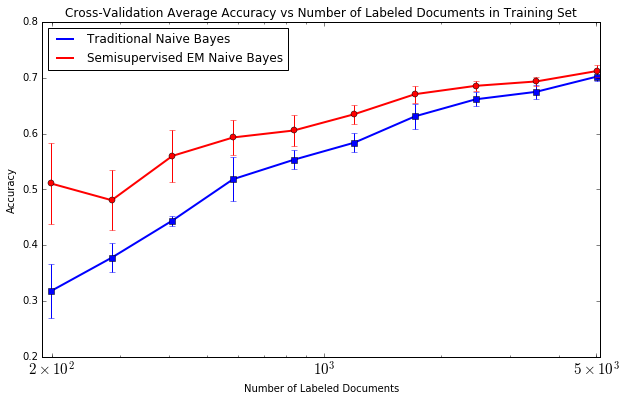

In [51]:
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['accuracy'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['accuracy'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, em_nb_score_mean, color='r', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average Accuracy vs Number of Labeled Documents in Training Set')

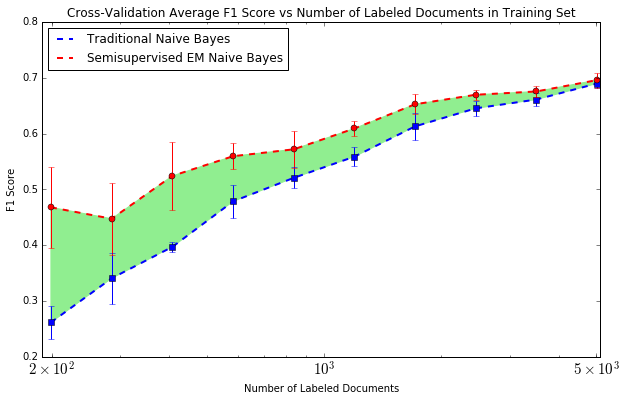

In [52]:
# plot CV F1 Score comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['f1_score'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['f1_score'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linestyle='--', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, em_nb_score_mean, color='r', linestyle='--', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='lightgreen')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('F1 Score')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average F1 Score vs Number of Labeled Documents in Training Set')

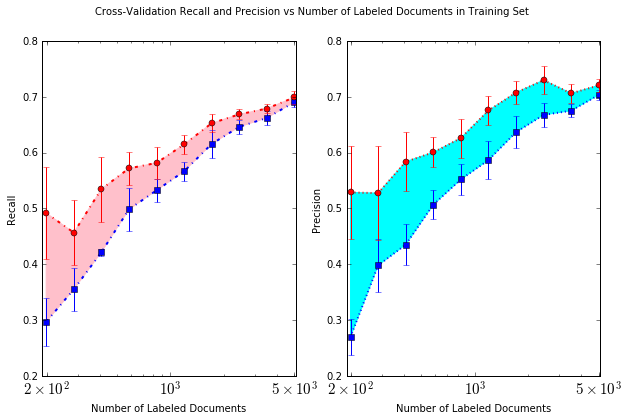

In [53]:
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['recall'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['recall'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax1.plot(experiments, nb_score_mean, color='b', linestyle='-.', linewidth=2, label='Traditional Naive Bayes')
ax1.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax1.plot(experiments, em_nb_score_mean, color='r', linestyle='-.', linewidth=2, label='Semisupervised EM Naive Bayes')
ax1.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax1.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='pink')
ax1.set_xlabel('Number of Labeled Documents')
ax1.set_ylabel('Recall')
ax1.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax1.set_xscale('log')
ax1.set_xticks([200, 1000, 5000]) 
ax1.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['precision'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['precision'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
ax2 = fig.add_subplot(122)
ax2.plot(experiments, nb_score_mean, color='b', linestyle=':', linewidth=2, label='Traditional Naive Bayes')
ax2.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax2.plot(experiments, em_nb_score_mean, color='r', linestyle=':', linewidth=2, label='Semisupervised EM Naive Bayes')
ax2.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax2.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='aqua')
ax2.set_xlabel('Number of Labeled Documents')
ax2.set_ylabel('Precision')
ax2.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax2.set_xscale('log')
ax2.set_xticks([200, 1000, 5000]) 
ax2.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
fig.suptitle('Cross-Validation Recall and Precision vs Number of Labeled Documents in Training Set')
plt.show()

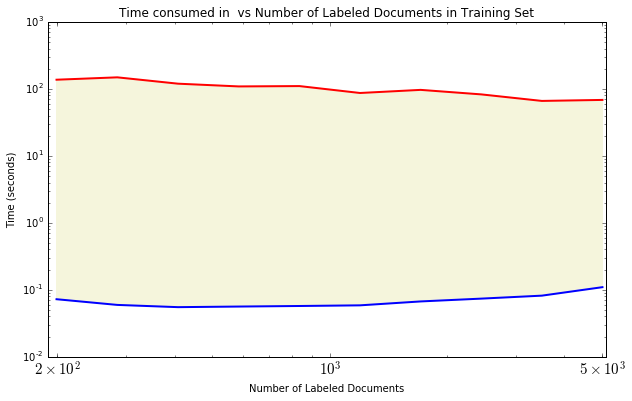

In [54]:
# plot time consuming in EM NB training process
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_cv_times, color='b', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_cv_times, color='r', linestyle='-', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.fill_between(experiments, nb_cv_times, em_nb_cv_times, color='beige')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Time (seconds)')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.title('Time consumed in  vs Number of Labeled Documents in Training Set')

In [24]:
# Evaluate original NB classifier using test data set
nb_test_scores = dict()
nb_test_scores['accuracy'] = list()
nb_test_scores['recall'] = list()
nb_test_scores['precision'] = list()
nb_test_scores['f1_score'] = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2).fit(X_l[:n_l_docs,], y_l[:n_l_docs])
    pred = nb_clf.predict(test_vec)
    accuracy = metrics.accuracy_score(test_y, pred)
    nb_test_scores['accuracy'].append(accuracy)
    nb_test_scores['recall'].append(metrics.recall_score(test_y, pred, average='macro'))
    nb_test_scores['precision'].append(metrics.precision_score(test_y, pred, average='macro'))
    nb_test_scores['f1_score'].append(metrics.f1_score(test_y, pred, average='macro'))
    print("%6d labeled documents lead to accuracy of %.3f" % (n_l_docs, accuracy))

   199 labeled documents lead to accuracy of 0.401
   285 labeled documents lead to accuracy of 0.425
   408 labeled documents lead to accuracy of 0.470
   584 labeled documents lead to accuracy of 0.512
   836 labeled documents lead to accuracy of 0.547
  1196 labeled documents lead to accuracy of 0.594
  1711 labeled documents lead to accuracy of 0.623
  2448 labeled documents lead to accuracy of 0.649
  3503 labeled documents lead to accuracy of 0.677
  5011 labeled documents lead to accuracy of 0.693


In [25]:
# Evaluate semi-supervised EM NB classifier using test data set
em_nb_test_scores = dict()
em_nb_test_scores['accuracy'] = list()
em_nb_test_scores['recall'] = list()
em_nb_test_scores['precision'] = list()
em_nb_test_scores['f1_score'] = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False).fit(X_l[:n_l_docs,], y_l[:n_l_docs], X_u)
    pred = em_nb_clf.predict(test_vec)
    accuracy = metrics.accuracy_score(test_y, pred)
    em_nb_test_scores['accuracy'].append(accuracy)
    em_nb_test_scores['recall'].append(metrics.recall_score(test_y, pred, average='macro'))
    em_nb_test_scores['precision'].append(metrics.precision_score(test_y, pred, average='macro'))
    em_nb_test_scores['f1_score'].append(metrics.f1_score(test_y, pred, average='macro'))
    print("%6d labeled documents lead to accuracy of %.3f" % (n_l_docs, accuracy))

   199 labeled documents lead to accuracy of 0.524
   285 labeled documents lead to accuracy of 0.550
   408 labeled documents lead to accuracy of 0.580
   584 labeled documents lead to accuracy of 0.602
   836 labeled documents lead to accuracy of 0.609
  1196 labeled documents lead to accuracy of 0.634
  1711 labeled documents lead to accuracy of 0.649
  2448 labeled documents lead to accuracy of 0.675
  3503 labeled documents lead to accuracy of 0.699
  5011 labeled documents lead to accuracy of 0.705


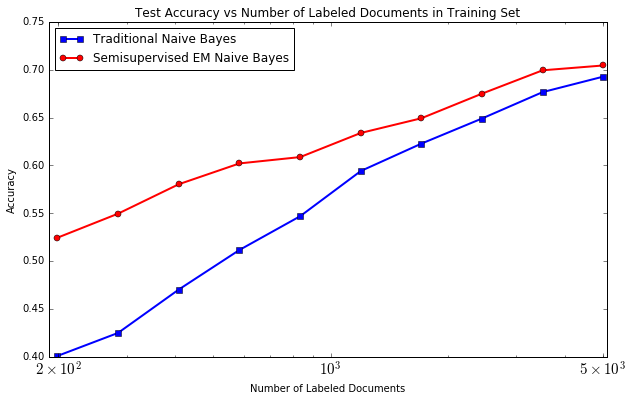

In [55]:
# Plot and compare test accuracy metrics
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_test_scores['accuracy'], color='b', marker='s', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_test_scores['accuracy'], color='r', marker='o', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Test Accuracy vs Number of Labeled Documents in Training Set')

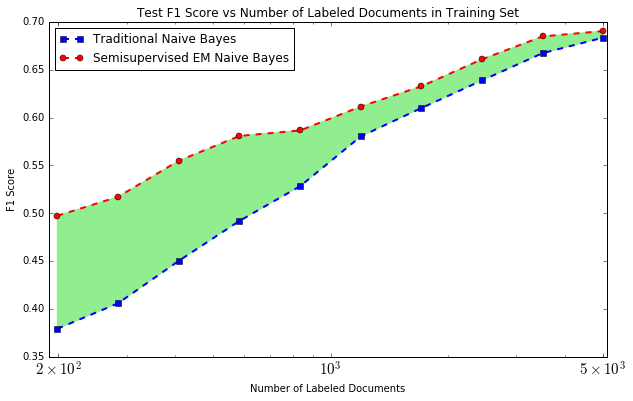

In [56]:
# Plot and compare test f1 score metrics
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_test_scores['f1_score'], color='b', marker='s', linestyle='--', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_test_scores['f1_score'], color='r', marker='o', linestyle='--', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.fill_between(experiments, nb_test_scores['f1_score'], em_nb_test_scores['f1_score'], color='lightgreen')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('F1 Score')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Test F1 Score vs Number of Labeled Documents in Training Set')

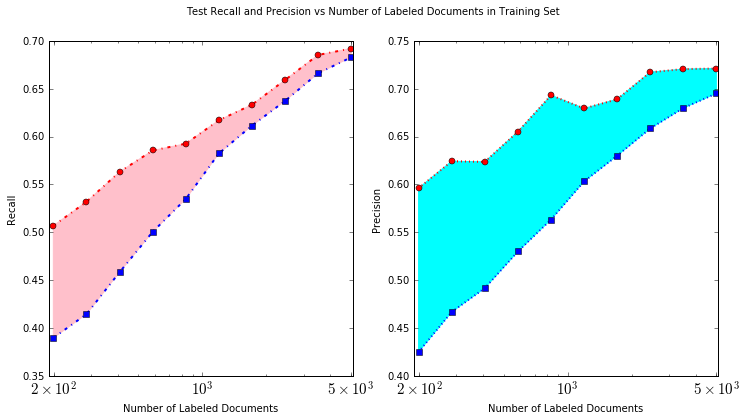

In [57]:
# Plot and compare test recall and precisions metrics
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(experiments, nb_test_scores['recall'], color='b', marker='s', linestyle='-.', linewidth=2, label='Traditional Naive Bayes')
ax1.plot(experiments, em_nb_test_scores['recall'], color='r', marker='o', linestyle='-.', linewidth=2, label='Semisupervised EM Naive Bayes')
ax1.fill_between(experiments, nb_test_scores['recall'], em_nb_test_scores['recall'], color='pink')
ax1.set_xlabel('Number of Labeled Documents')
ax1.set_ylabel('Recall')
ax1.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax1.set_xscale('log')
ax1.set_xticks([200, 1000, 5000]) 
ax1.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)

ax2 = fig.add_subplot(122)
ax2.plot(experiments, nb_test_scores['precision'], color='b', marker='s', linestyle=':', linewidth=2, label='Traditional Naive Bayes')
ax2.plot(experiments, em_nb_test_scores['precision'], color='r', marker='o', linestyle=':', linewidth=2, label='Semisupervised EM Naive Bayes')
ax2.fill_between(experiments, nb_test_scores['precision'], em_nb_test_scores['precision'], color='aqua')
ax2.set_xlabel('Number of Labeled Documents')
ax2.set_ylabel('Precision')
ax2.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax2.set_xscale('log')
ax2.set_xticks([200, 1000, 5000]) 
ax2.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
fig.suptitle('Test Recall and Precision vs Number of Labeled Documents in Training Set')
plt.show()